The RELU activation function is, although technically nonlinear, comprised of linear functions (piece-wise). So, is it as effective and efficient in modelling/approximating any line like other exponential activation functions in a neural network?
===

Effective?
  1. Can a set of RELUs accurately model a line?
  2. Will a set of RELUs learn the function in a neural network using, for example, SGD and back-prop?
  
Efficient?
  1. Are a set of RELUs computationally efficient versus some other set of neurons with a different activation function?
  2. Will all the RELU neurons be used to closely approximate the target function? Or will a bunch be effectively dead and not contributing?
  
Investigating learning simple functions of one input to one output using a network with a single hidden layer that has an output activation function that is either RELU or tanh()...

The answers, even for this simple case, appear to be: Yes, Often, Usually, Sometimes. In slightly more detail:
  1. RELUs are effective and efficient for simple, smooth functions.
  2. For more complex functions, the RELUs may "bunch up" during training and then be unable to move their knots downhill towards the remaining error-filled portion of the line.
  3. In extreme cases, e.g. high output bias, the RELUs may all commit suicide by attempting to fix the bias by biasing themselves out of the problem domain.
  
Dropout, normalization, sparsity constraints, incremental neuron addition, and other techniques would all help address these limitations.



In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

sess = tf.InteractiveSession()

The target functions
==

Note the f4() looks monotonic and trivial, but actually needs high bias and scaling because the y-values are far from zero.

Note also that f5() and f6() should be prefectly approximable by a few RELU neurons.

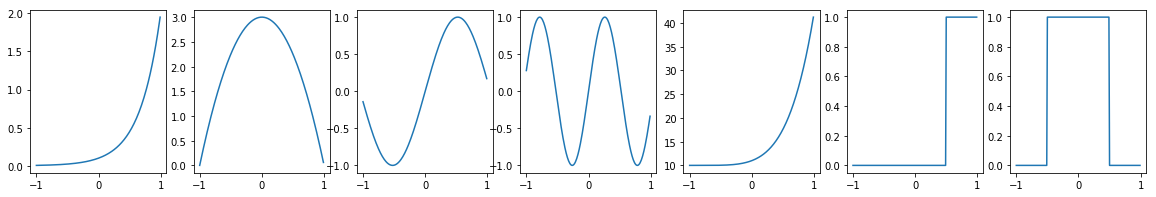

In [14]:
xx = np.arange(-1, 1, .01)

def f0(x): return np.exp(3*x) / 10
def f1(x): return 3-3*x*x
def f2(x): return np.sin(3*x)
def f3(x): return np.sin(6*x)
def f4(x): return 10+(1+x)**5
def f5(x): return (x > .5) * 1.
def f6(x): return (np.abs(x) < .5) * 1.


fns = [ f0, f1, f2, f3, f4, f5, f6 ]
fig = plt.figure(figsize=(20, 3))
p = 1
for f in fns:
    ax = fig.add_subplot(1, len(fns), p)
    p = p + 1
    y = f(xx)
    plt.plot(xx,y)
plt.show()


Weight initialization
==

Standard small random initialization for both weights and biases.

In [15]:
x = tf.placeholder(tf.float32, shape=[None, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)


The network
==

The network could be just a dot-product + bias to get a hidden layer, then an activation function per neuron, then a final dot product to get the single output.

To make things easier on the RELU, we'll remove the initial dot product, but keep the initial bias. This is, of course, unfair to the tanh() version: it needs the first layer weights to control the steepness of its response.

Also, we'll keep our hidden layer small: more than enough neurons to learn a good approximation, but few enough that efficiency failures will be visible.

In [16]:
h1Sz = 8
dualWeights = False

def mkNet(act):
    if dualWeights:
        W1 = weight_variable([1, h1Sz])
        b1 = bias_variable([h1Sz])
        h = act(tf.matmul(x, W1) + b1)
    else:
        b1 = bias_variable([h1Sz])
        h = act(x + b1)

    W2 = weight_variable([h1Sz, 1])
    b2 = bias_variable([1])

    y = tf.matmul(h, W2) + b2
    loss = (y-y_)**2
    train = tf.train.GradientDescentOptimizer(.003).minimize(loss)
    return y, loss, train, (b1, W2, b2), h

In [17]:
def doit(act, f):
    n, loss, train, wgts, h = mkNet(act)

    sess.run(tf.global_variables_initializer())

    # display progress stuff
    fig = plt.figure(figsize=(12, 12))
    p = [1]
    
    tPer = 1000
    disp = [int(3**_) for _ in range(12)]
    disp = [ x for x in disp if x < tPer*10 ]
    nRows = (len(disp)+1+1) // 2
    
    def pp(t):
        """show target fn & our prediction, then the hidden contribbutions"""
        ax = fig.add_subplot(nRows, 4, p[0])
        p[0] += 1
        
        y, w, hd = sess.run((n, wgts, h), feed_dict={ x: xx.reshape(-1, 1) })

        plt.title('epoch %d' % t)
        plt.plot(xx, y)
        plt.plot(xx, f(xx))

        ax = fig.add_subplot(nRows, 4, p[0])
        p[0] += 1
        
        for hx, wo in zip(hd.T, w[1]):
            plt.plot(xx, hx*wo)
   
    t = 0
     
    # train the network...
    
    for j in range(10):
        y = f(xx.reshape(-1, 1))
        y, l = sess.run((n, loss), feed_dict={ x: xx.reshape(-1, 1), y_: y })
        print('true loss:', np.sum(l))
        
        for i in range(tPer):
            t += 1
            if t in disp:
                pp(t)
            d = np.random.uniform(-1, 1, size=(10,1))
            y = f(d)
            _ = sess.run(train, feed_dict={ x: d, y_: y })
    
    pp(t)
    plt.tight_layout()
    
    plt.show()

true loss: 30.4498
true loss: 1.62221
true loss: 0.704603
true loss: 0.351375
true loss: 0.20162
true loss: 0.130669
true loss: 0.093323
true loss: 0.0736022
true loss: 0.0593467
true loss: 0.0491971


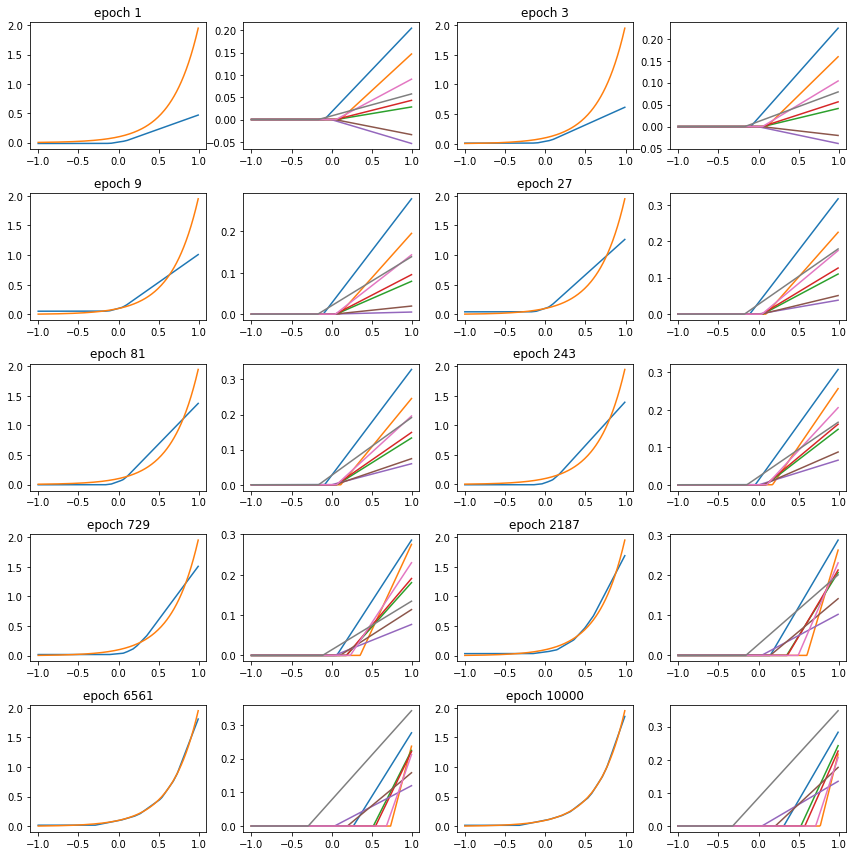

true loss: 62.4137
true loss: 6.40038
true loss: 2.94301
true loss: 2.26035
true loss: 1.87134
true loss: 1.65227
true loss: 1.39204
true loss: 1.31392
true loss: 1.16943
true loss: 1.09542


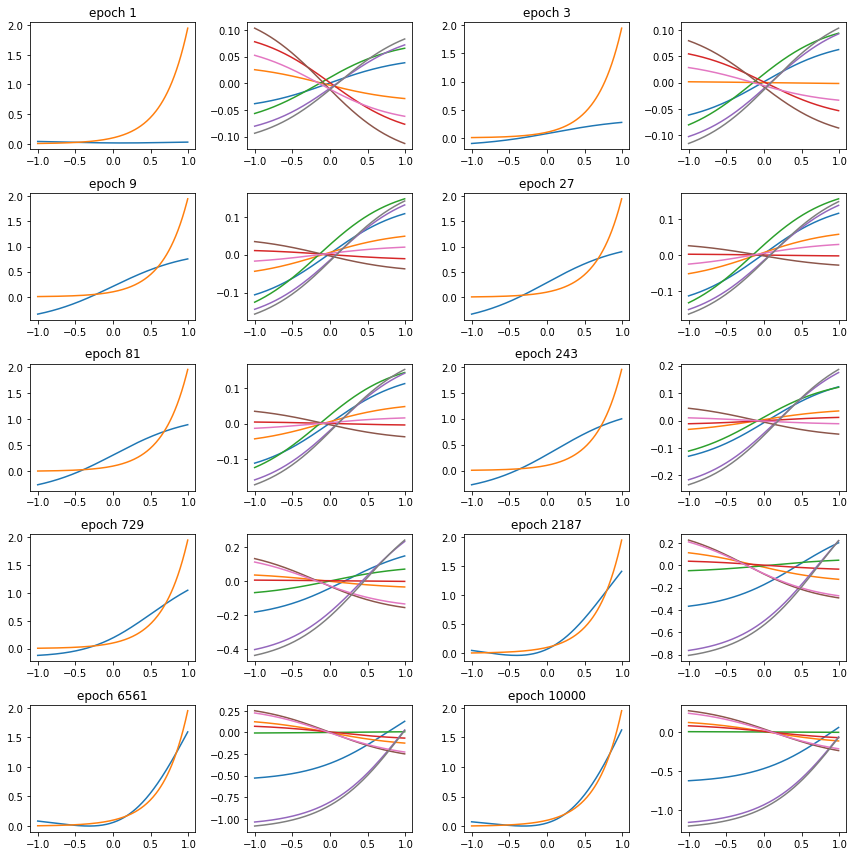

In [18]:
doit(tf.nn.relu, f0)
doit(tf.nn.tanh, f0)

true loss: 957.807
true loss: 10.7117
true loss: 4.36917
true loss: 1.81568
true loss: 1.12774
true loss: 0.781422
true loss: 0.571601
true loss: 0.539839
true loss: 0.432817
true loss: 0.426283


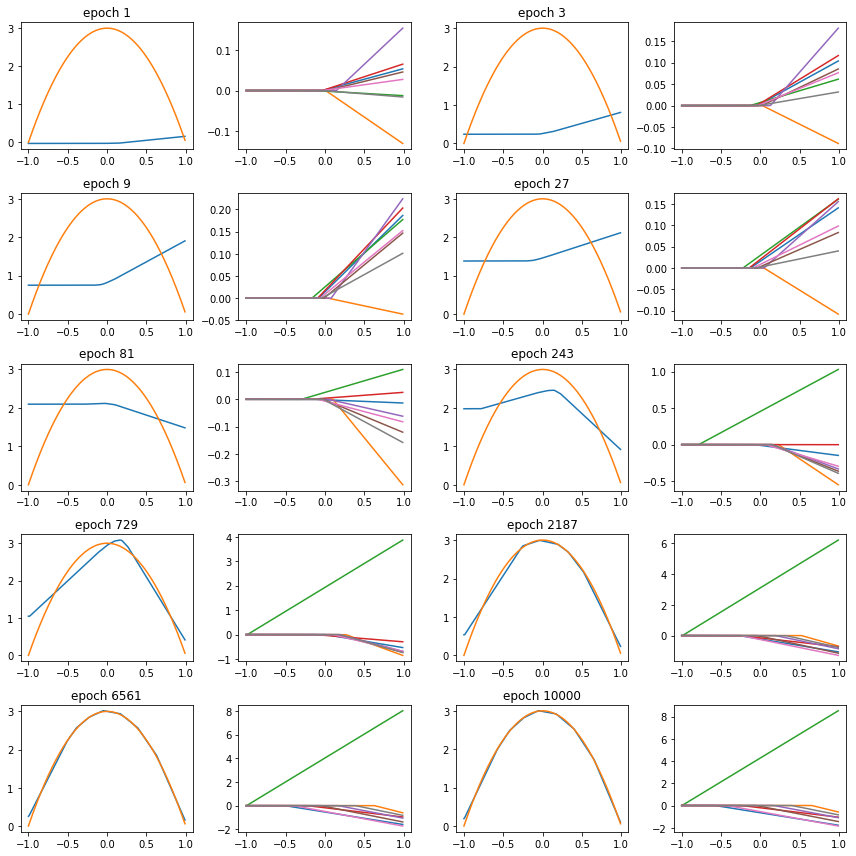

true loss: 1051.94
true loss: 12.7947
true loss: 2.492
true loss: 1.6293
true loss: 1.47368
true loss: 1.49702
true loss: 1.30345
true loss: 1.25448
true loss: 1.16417
true loss: 1.20781


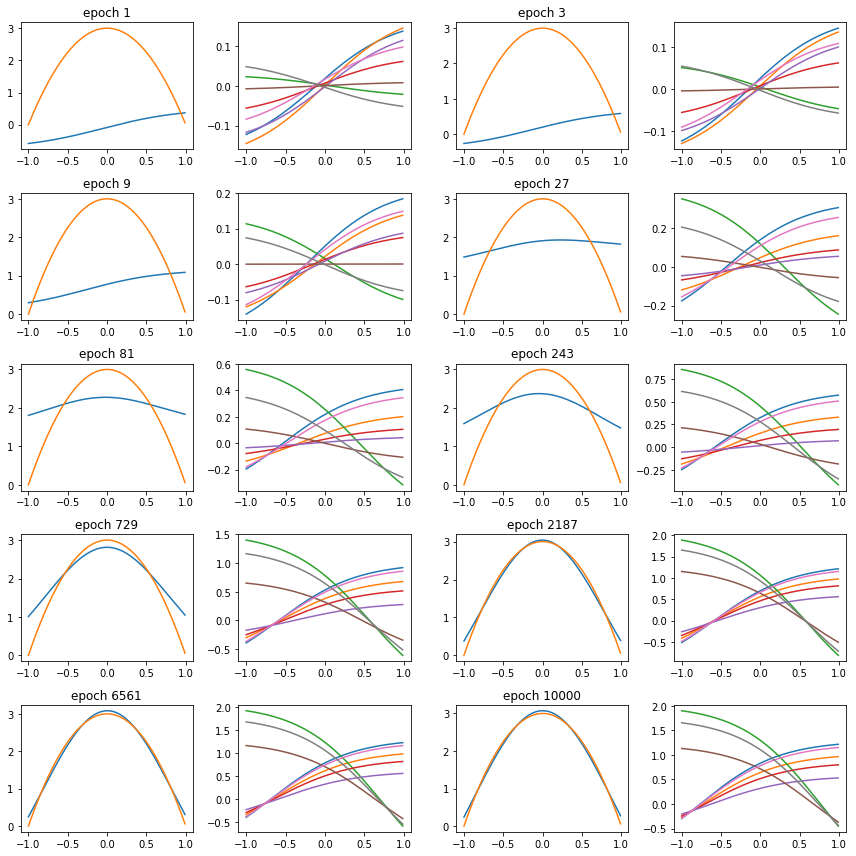

In [19]:
doit(tf.nn.relu, f1)
doit(tf.nn.tanh, f1)

true loss: 83.091
true loss: 8.5064
true loss: 5.26155
true loss: 4.79162
true loss: 4.6294
true loss: 4.53852
true loss: 4.49623
true loss: 4.49105
true loss: 4.46675
true loss: 4.46392


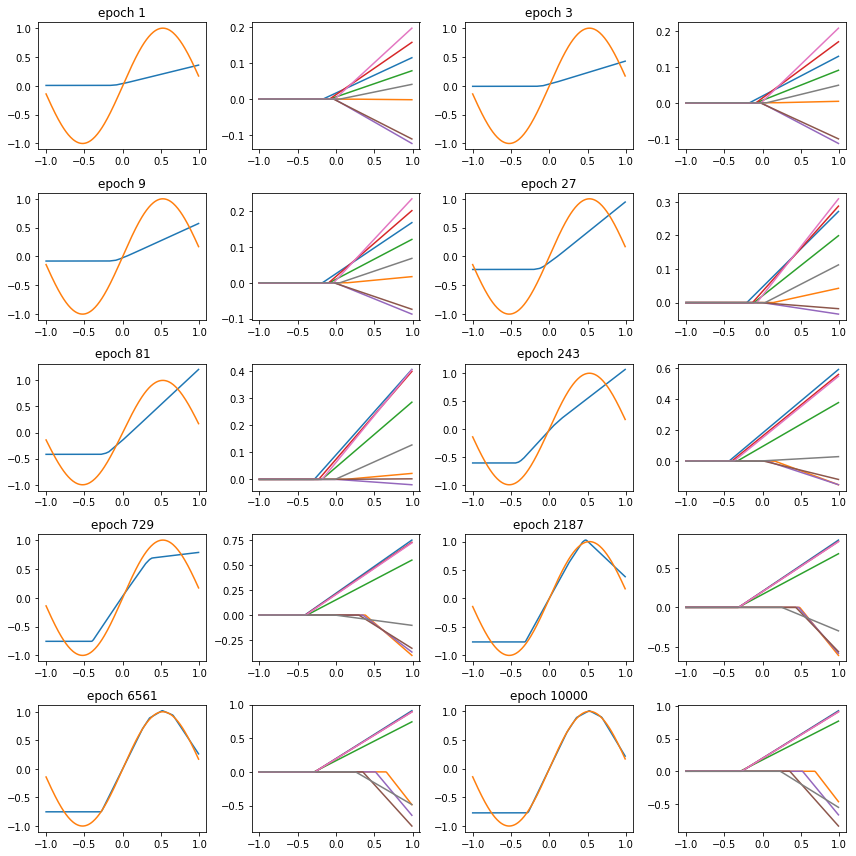

true loss: 70.9949
true loss: 26.8775
true loss: 27.3034
true loss: 26.3631
true loss: 27.6564
true loss: 26.3532
true loss: 26.619
true loss: 26.4643
true loss: 26.9427
true loss: 26.7895


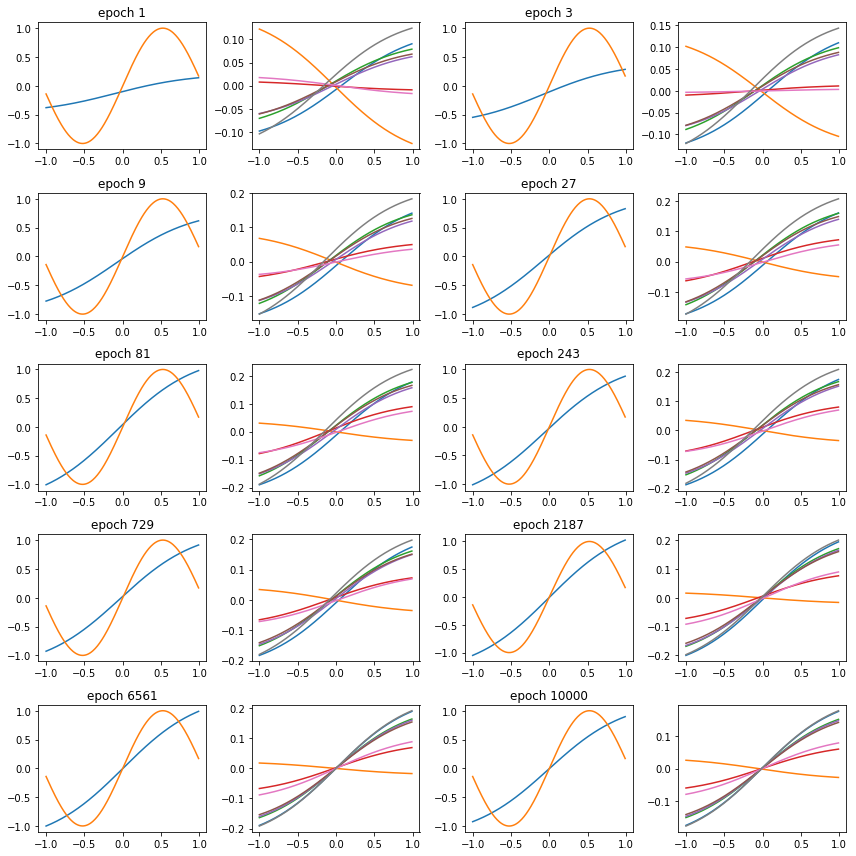

In [20]:
doit(tf.nn.relu, f2)
doit(tf.nn.tanh, f2)

true loss: 108.456
true loss: 66.4656
true loss: 63.1199
true loss: 62.1939
true loss: 62.027
true loss: 62.2032
true loss: 61.6155
true loss: 61.976
true loss: 61.8599
true loss: 64.9368


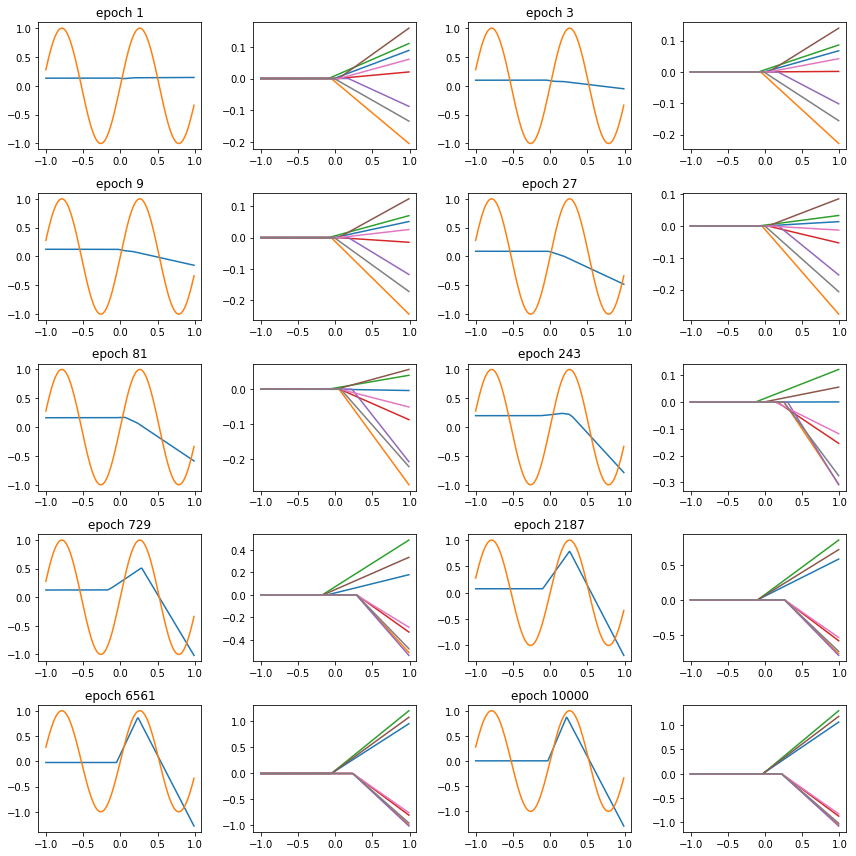

true loss: 108.338
true loss: 90.6
true loss: 89.4505
true loss: 82.7996
true loss: 76.5097
true loss: 72.496
true loss: 68.7036
true loss: 70.3719
true loss: 68.1123
true loss: 68.0588


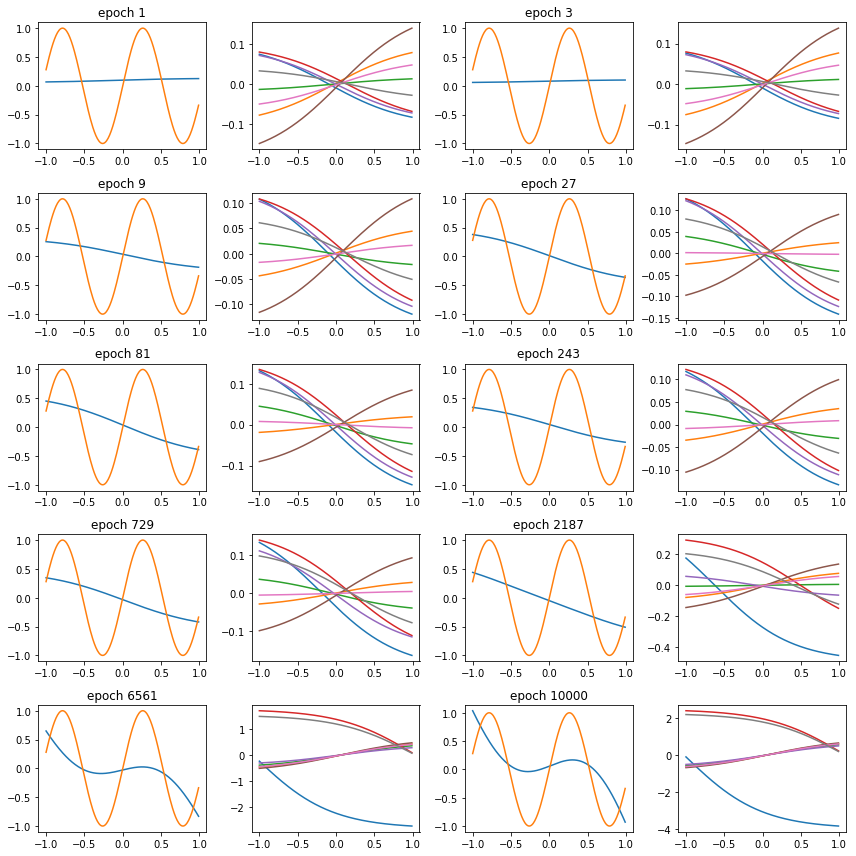

In [21]:
doit(tf.nn.relu, f3)
doit(tf.nn.tanh, f3)

Complete bias suicide:
===

true loss: 57946.8
true loss: 12611.9
true loss: 12624.8
true loss: 12601.5
true loss: 12607.6
true loss: 12604.5
true loss: 12625.5
true loss: 12614.3
true loss: 12721.4
true loss: 12638.5


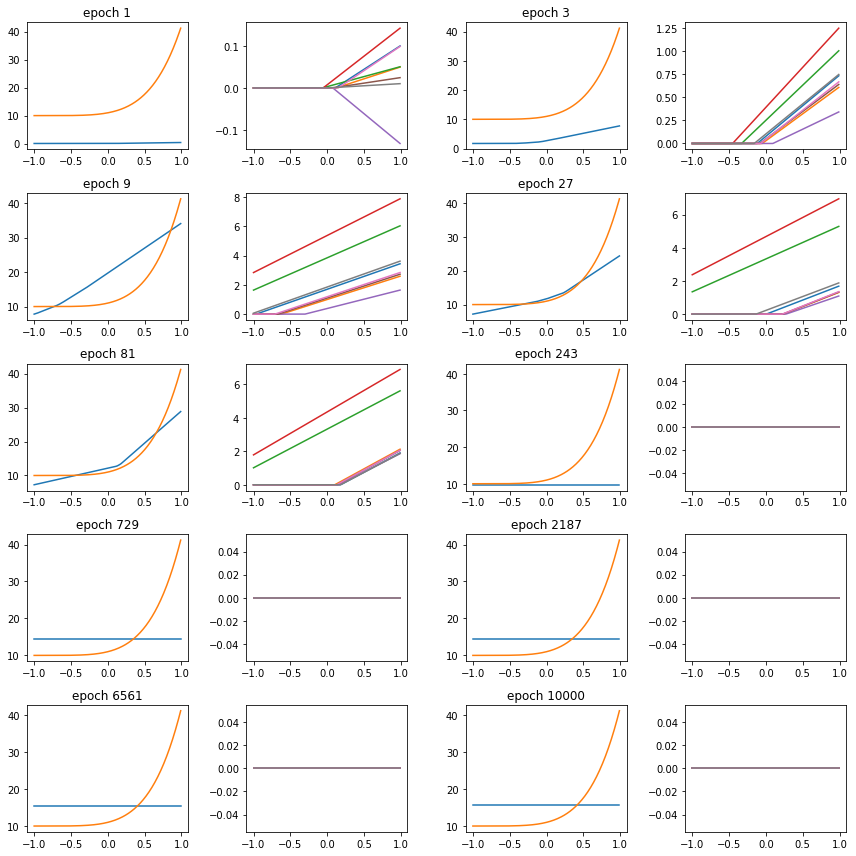

true loss: 59113.2
true loss: 3337.85
true loss: 4654.63
true loss: 2984.37
true loss: 7823.26
true loss: 2166.26
true loss: 2250.89
true loss: 10692.0
true loss: 1620.78
true loss: 1941.35


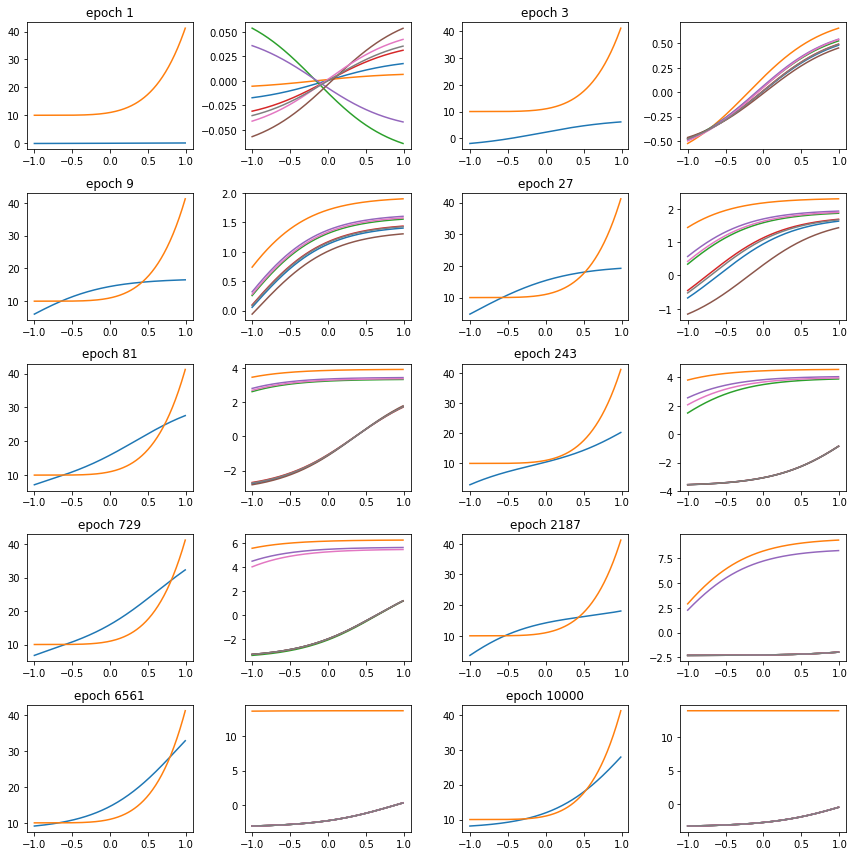

In [22]:
doit(tf.nn.relu, f4)
doit(tf.nn.tanh, f4)

Bunching up:
===

true loss: 15.1081
true loss: 5.73596
true loss: 5.57608
true loss: 5.60187
true loss: 5.5623
true loss: 5.58159
true loss: 5.56835
true loss: 5.56796
true loss: 5.60066
true loss: 5.57946


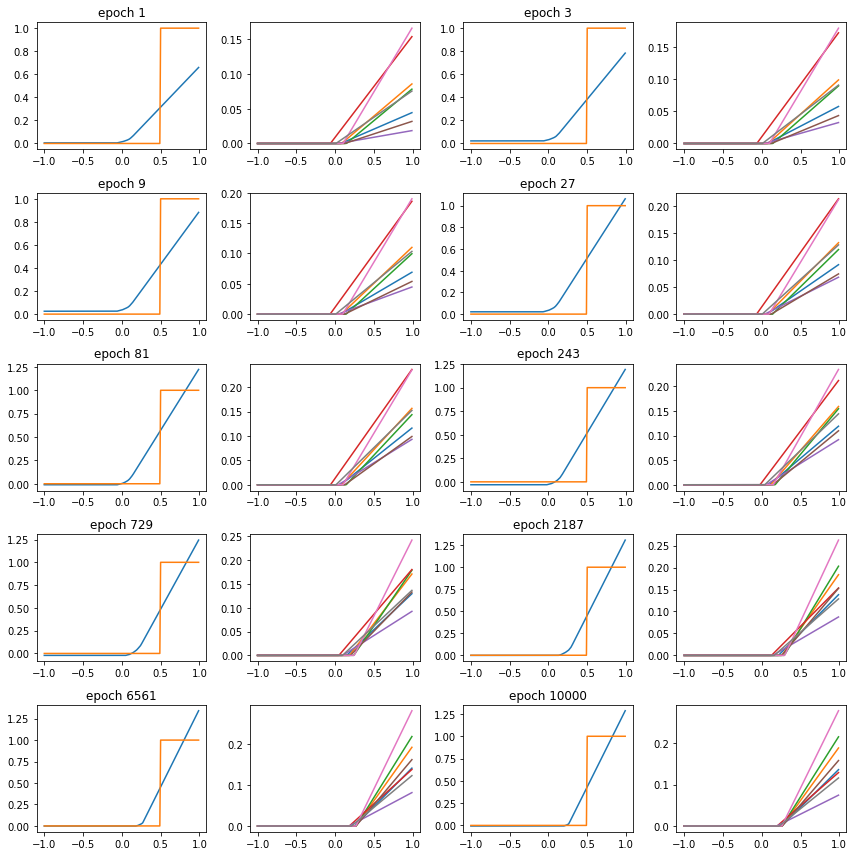

true loss: 48.2312
true loss: 10.884
true loss: 7.24246
true loss: 6.87879
true loss: 6.71048
true loss: 6.68364
true loss: 6.71827
true loss: 6.6679
true loss: 6.67175
true loss: 6.72299


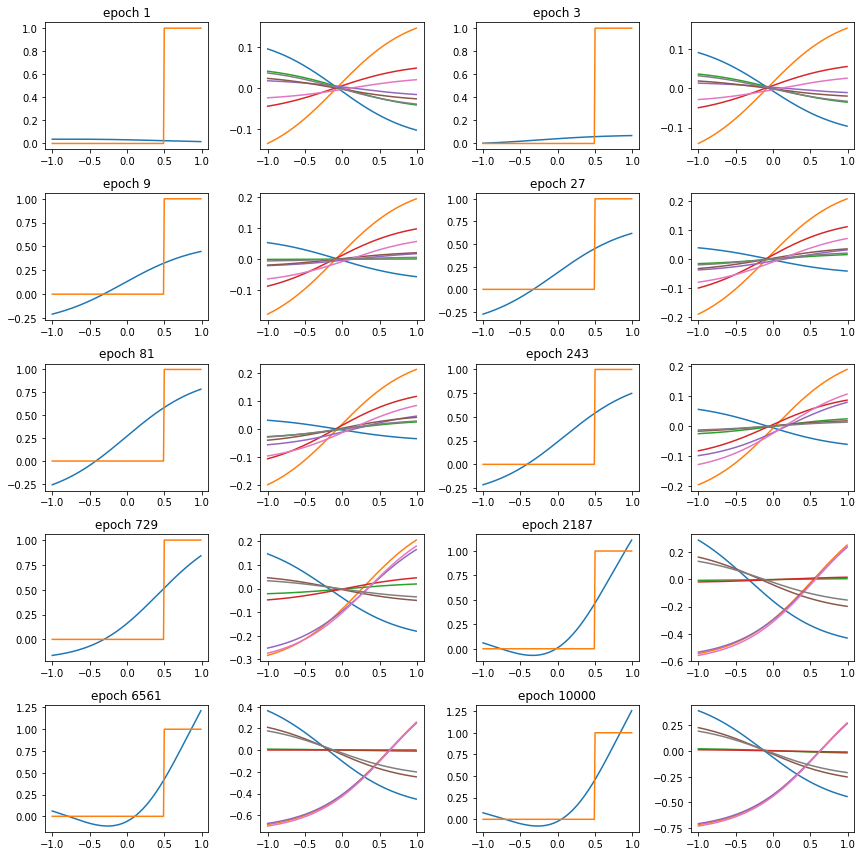

In [23]:
doit(tf.nn.relu, f5)
doit(tf.nn.tanh, f5)

true loss: 91.813
true loss: 13.7131
true loss: 11.2647
true loss: 10.2631
true loss: 9.7624
true loss: 9.35466
true loss: 9.12223
true loss: 8.89016
true loss: 8.93324
true loss: 8.69303


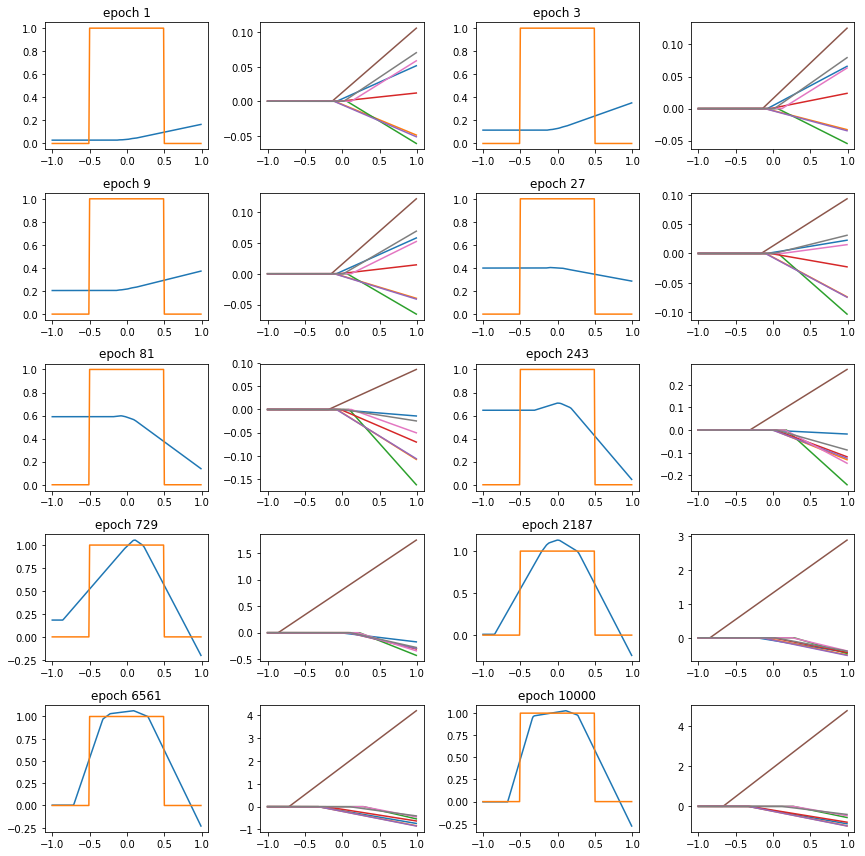

true loss: 93.9357
true loss: 18.3524
true loss: 12.836
true loss: 12.2994
true loss: 12.1784
true loss: 11.9722
true loss: 12.1074
true loss: 12.1976
true loss: 11.9241
true loss: 12.047


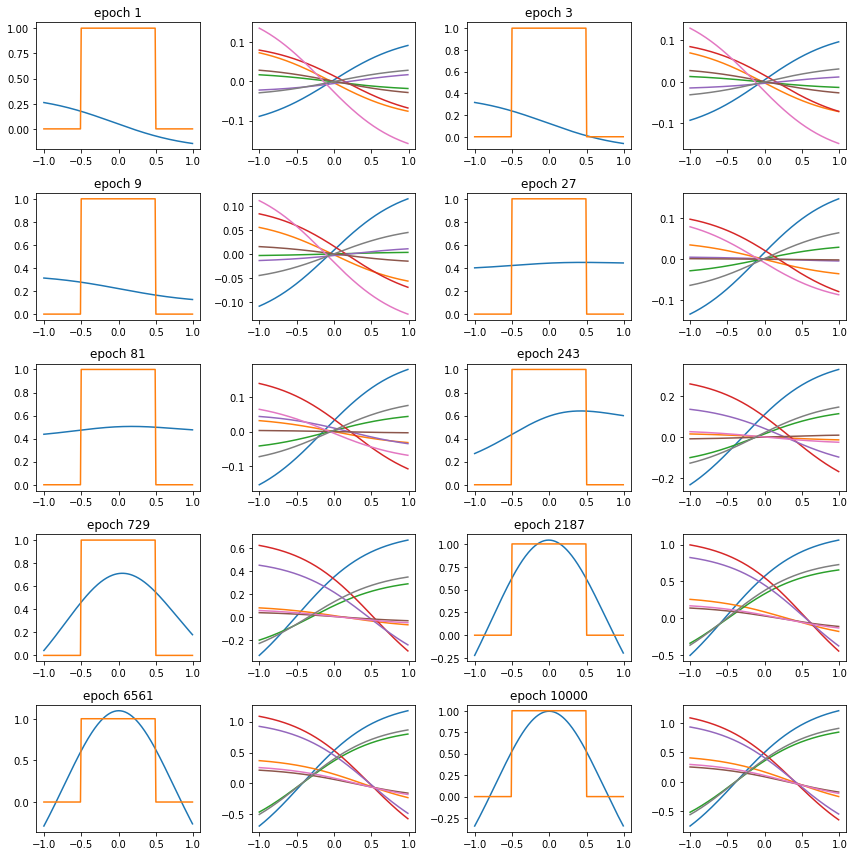

In [24]:
doit(tf.nn.relu, f6)
doit(tf.nn.tanh, f6)